In [7]:
import numpy as np
import mdtraj as md
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

t = md.load('path.xtc', top='path.pdb')

cont_file = '/mnt/c/users/t_m_w/moleculardynamics/1ubqcalpha/1ubqca.contacts'
# cont_file refers to native contact files produced by graining with the Smog-Server https://smog-server.org/prepare_a_simulation.html, 
# although the data can be worked using the standard mdtraj pair selections
# use whichever pair selection you prefer, however i've seen a greater accuracy and much cleaner heatmaps for the probability using the smog server files 
#heavy = native.topology.select_atom_indices('heavy')
#heavy_pairs = np.array(
#        [(i,j) for (i,j) in combinations(heavy, 2)
#            if abs(native.topology.atom(i).residue.index - \
#                   native.topology.atom(j).residue.index) > 3])

def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """

   
    beta_const = 50 # 1/nm
    lambda_const = 1.6 #this is for AA i will decipher ca
    native_cutoff = 0.4 # nm
    
    
    
    df = pd.read_csv(cont_file, sep='\s+', usecols=[1, 3])
    print(df)
    capairs = df.values

    pairs_dist = md.compute_distances(native, capairs)
   
    native_contacts = capairs[np.any(pairs_dist < native_cutoff)]
    
    nativ2d = native_contacts.reshape(-1,2)
    
    r =  md.compute_distances(t, nativ2d)

    r0 = md.compute_distances(native[0], nativ2d)
    
    q = 1.0/(1+np.exp(beta_const*(r-lambda_const*r0)))
    
    return q, capairs
 

q, capairs = best_hummer_q(t, t[0])

<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_45918/3291949135.py:43: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(cont_file, sep='\s+', usecols=[1, 3])


     1.1  15
0      1  16
1      1  17
2      1  18
3      1  19
4      1  56
..   ...  ..
200   56  67
201   57  61
202   60  65
203   61  65
204   61  67

[205 rows x 2 columns]


/tmp/ipykernel_45918/3291949135.py:57: RuntimeWarning: overflow encountered in exp
  q = 1.0/(1+np.exp(beta_const*(r-lambda_const*r0)))


In [8]:
dmap = md.geometry.squareform(q, capairs)
cmap = np.mean(dmap, axis = 0)

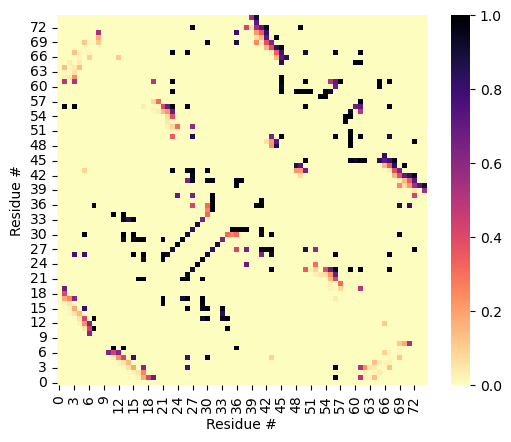

In [9]:
sns.heatmap(cmap, cmap = 'magma_r', square=True)
plt.gca().invert_yaxis()
plt.xlabel('Residue #')
plt.ylabel('Residue #')
plt.show()

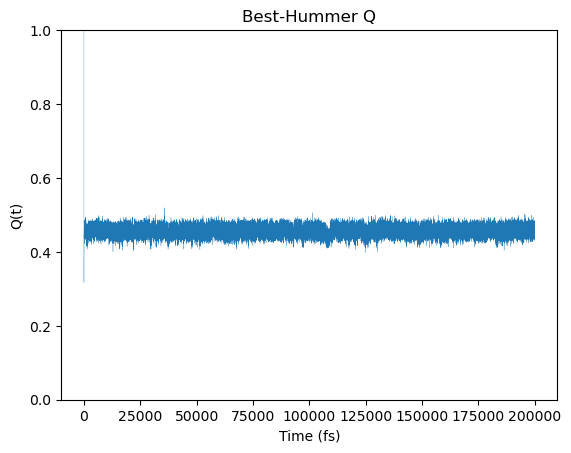

In [7]:
qt = np.mean(q, axis = 1)
ymin, ymax = 0, 1
plt.plot(qt, linewidth = 0.2)
plt.ylim(ymin, ymax)
plt.xlabel('Time (fs)')
plt.ylabel('Q(t)')
plt.title('Best-Hummer Q')
plt.savefig('Best-Hummer Q.jpg')

In [14]:
import mdtraj as md
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

t = md.load('path.xtc', top='path.pdb')

cont_file = '/mnt/c/users/t_m_w/moleculardynamics/1ubqcalpha/1ubqca.contacts' 
# cont_file refers to native contact files produced by graining with the Smog-Server https://smog-server.org/prepare_a_simulation.html, 
# although the data can be worked using the standard mdtraj pair selections
# use whichever pair selection you prefer, however i've seen a greater accuracy and much cleaner heatmaps for the probability using the smog server files 
#heavy = native.topology.select_atom_indices('heavy')
#heavy_pairs = np.array(
#        [(i,j) for (i,j) in combinations(heavy, 2)
#            if abs(native.topology.atom(i).residue.index - \
#                   native.topology.atom(j).residue.index) > 3])

def qplot(traj, cont_file):
    pairslist = pd.read_csv(cont_file, sep='\s+', usecols=[1, 3])
    capairs = pairslist.values
    natcounts = len(capairs)
    natrng = md.compute_distances(t[0], capairs)
    natmod = natrng*1.5
    conts = md.compute_distances(t, capairs)
    frmconts = np.greater(natmod, conts)
    frmcounts = []
    counts = 0

    for row in frmconts:
        for element in row:
            if element == True:
                counts += 1
        frmcounts.append(counts)
        counts = 0

    qt = []
    qf = 0
    for i in frmcounts:
        qf = i/natcounts
        qt.append(qf)
        qf = 0

    return qt

qt = qplot(t, cont_file)

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_45918/3559066655.py:11: SyntaxWarning: invalid escape sequence '\s'
  pairslist = pd.read_csv(cont_file, sep='\s+', usecols=[1, 3])


In [ ]:
sns.heatmap(cmapq, cmap = 'magma_r', square=True)
plt.gca().invert_yaxis()
plt.xlabel('Residue #')
plt.ylabel('Residue #')
plt.show()

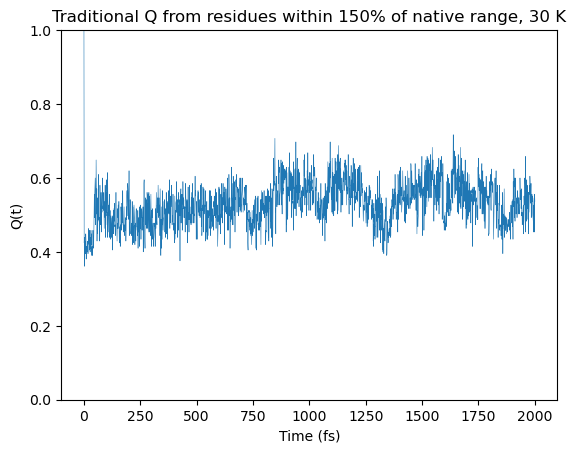

In [15]:
ymin, ymax = 0, 1

plt.plot(qt, linewidth = 0.4)
plt.ylim(ymin, ymax)
plt.xlabel('Time (fs)')
plt.ylabel('Q(t)')
plt.title('Traditional Q from residues within 150% of native range, 30 K')
plt.savefig('Traditional Q 150.jpg')